In [1]:
import time

from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium_stealth import stealth
from webdriver_manager.chrome import ChromeDriverManager

from selenium.webdriver.common.by import By
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.support.ui import WebDriverWait
from selenium.common.exceptions import TimeoutException, NoSuchElementException

import pandas as pd
from bs4 import BeautifulSoup

# Get Links to Recipes

In [3]:
def get_driver():
    service = Service(ChromeDriverManager().install())
    driver = webdriver.Chrome(service=service)
    stealth(
        driver,
        languages=["en-US", "en"],
        vendor="Google Inc.",
        platform="Win32",
        webgl_vendor="Intel Inc.",
        renderer="Intel Iris OpenGL Engine",
        fix_hairline=True,
    )
    return driver

In [4]:
driver = get_driver()

url = "https://www.skinnytaste.com/recipe-index/"
driver.get(url)
time.sleep(5)

soup = BeautifulSoup(driver.page_source, 'html.parser')

recipe_links = []
page = 1

while page <= 50:
    # Important to wait for some time to let the links update for the next page. Otherwise
    # soup will extract the same links of the previous page.
    time.sleep(5)

    # Since we are visiting a new page, we have to create a new bs4 object with current page source.
    soup = BeautifulSoup(driver.page_source, 'html.parser')
    
    links = soup.select('.entry-header .entry-title a')
    for link in links:
        recipe_links.append(link['href'])
        print(f"Adding {link['href']}")

    try:
        wait = WebDriverWait(driver, 15)
        page_link = wait.until(
            EC.element_to_be_clickable(
                (By.XPATH, 
                 '//a[@class="facetwp-page" and @data-page="' + str(page + 1) + '"]')
            )
        )
        page += 1

        # There is a signin overlay in the website. It disables any clicking functionality.
        # So, we have to use JavaScript to click on the next pages.
        driver.execute_script("arguments[0].click();", page_link)
    except TimeoutException:
        # If next page buttons are still not available after waiting for 15 seconds,
        # we will try again from the same page. That's why the page number is not updated.
        continue

driver.quit()

Adding https://www.skinnytaste.com/free-7-day-healthy-meal-plan-sept-30-oct-6/
Adding https://www.skinnytaste.com/freezer-breakfast-burritos/
Adding https://www.skinnytaste.com/crustless-pumpkin-pie/
Adding https://www.skinnytaste.com/red-curry-salmon/
Adding https://www.skinnytaste.com/apple-butter-recipe/
Adding https://www.skinnytaste.com/roasted-delicata-squash/
Adding https://www.skinnytaste.com/applesauce-nut-bread/
Adding https://www.skinnytaste.com/autumn-salad-with-pears-and-gorgonzola/
Adding https://www.skinnytaste.com/sesame-chicken/
Adding https://www.skinnytaste.com/bacon-in-the-oven/
Adding https://www.skinnytaste.com/skinny-pumpkin-spiced-latte/
Adding https://www.skinnytaste.com/homemade-hamburger-helper/
Adding https://www.skinnytaste.com/fried-brown-rice/
Adding https://www.skinnytaste.com/easy-sheet-pan-dinners/
Adding https://www.skinnytaste.com/asian-grilled-chicken-33-pts_3510/
Adding https://www.skinnytaste.com/sweet-potato-salad/
Adding https://www.skinnytaste.

In [5]:
len(recipe_links)

1000

In [6]:
with open("urls.txt", "w") as file:
    for link in recipe_links:
        file.write(link + "\n")

# Load Recipe Links

In [7]:
with open("urls.txt", "r") as file:
    recipe_links = [line.rstrip('\n') for line in file]

# Scrape Recipes

In [8]:
recipe_info = []
skipped_links = []
last_scraped = 0

In [21]:
for i, link in enumerate(recipe_links[:370]):

    driver = get_driver()

    driver.get(link)
    time.sleep(5)
    soup = BeautifulSoup(driver.page_source, 'html.parser')

    info = {}
    info['id'] = i

    try:
        name = soup.find('h2', class_='wprm-recipe-name')
        if name:
            try:
                info['name'] = name.text.strip()
            except KeyError as e:
                continue
        else:
            continue

        points = soup.select_one('.wprm-recipe-custom-field.wprm-recipe-custom-field-type-text')
        if points:
            info['points'] = points.get_text(strip=True)
        else:
            continue

        img = soup.select_one('.wprm-recipe-image-container img')
        if img:
            try:
                info['img'] = img['data-lazy-src'] or None
            except KeyError as e:
                continue
        else:
            continue

        calories = soup.find('span', class_='wprm-recipe-details wprm-recipe-nutrition wprm-recipe-calories wprm-block-text-bold')
        if calories:
            info['calories'] = calories.get_text(strip=True)
        else:
            continue

        summary = soup.find('div', class_='wprm-recipe-summary').find('span')
        if summary:
            info['summary'] = summary.get_text(strip=True)
        else:
            continue

        key_tags = soup.select('.post-meta-detail.post-types-snippet .cat-icons.post-icons a')
        if key_tags:
            keys = [anchor.get_text(strip=True) for anchor in key_tags]
            info['keys'] = " ".join(keys)
        else:
            continue

        recipe_info.append(info)
        last_scraped = i
        
        driver.quit()
    
    except Exception as e:
        print(f"Skipping {link['href']} - {e}")
        skipped_links.append(i)
        driver.quit()
        continue

In [22]:
print(last_scraped)

369


In [23]:
len(recipe_info)

822

# Save Dataset

In [24]:
dataset = pd.DataFrame(recipe_info)
dataset.to_csv("data.csv", index=False)

In [25]:
dataset.head(5)

,id,name,points,img,calories,summary,keys
0,0,Pasta Fagioli (Pasta and Beans),4,https://www.skinnytaste.com/wp-content/uploads...,262.5,Italian Pasta Fagioli (Pasta and Beans) is a g...,DF FM GF HF KF PC Q V
1,2,Raw Beet Salad with Apples and Carrots,2,https://www.skinnytaste.com/wp-content/uploads...,112,"Crunchy, bright and sweet, the healthy Raw Bee...",DF GF KF Q V
2,3,Teriyaki Shrimp Quinoa Bowls with Mango-Cucumb...,6,https://www.skinnytaste.com/wp-content/uploads...,352,These fresh and delicious Teriyaki Shrimp Quin...,DF GF HP HF
3,4,Black Beans and Rice,6,https://www.skinnytaste.com/wp-content/uploads...,236,This quick and easy recipe for Black Beans and...,DF FM GF KF V
4,6,Air Fryer Breakfast Banana Split,5,https://www.skinnytaste.com/wp-content/uploads...,286,"If you need a quick and healthy breakfast, you...",AF KF Q


# Load Dataset

In [2]:
dataset = pd.read_csv('./data.csv')
dataset.head(10)

,id,name,points,img,calories,summary,keys
0,0,Pasta Fagioli (Pasta and Beans),4,https://www.skinnytaste.com/wp-content/uploads...,262.5,Italian Pasta Fagioli (Pasta and Beans) is a g...,DF FM GF HF KF PC Q V
1,2,Raw Beet Salad with Apples and Carrots,2,https://www.skinnytaste.com/wp-content/uploads...,112.0,"Crunchy, bright and sweet, the healthy Raw Bee...",DF GF KF Q V
2,3,Teriyaki Shrimp Quinoa Bowls with Mango-Cucumb...,6,https://www.skinnytaste.com/wp-content/uploads...,352.0,These fresh and delicious Teriyaki Shrimp Quin...,DF GF HP HF
3,4,Black Beans and Rice,6,https://www.skinnytaste.com/wp-content/uploads...,236.0,This quick and easy recipe for Black Beans and...,DF FM GF KF V
4,6,Air Fryer Breakfast Banana Split,5,https://www.skinnytaste.com/wp-content/uploads...,286.0,"If you need a quick and healthy breakfast, you...",AF KF Q
5,7,Red Thai Coconut Curry Shrimp,2,https://www.skinnytaste.com/wp-content/uploads...,136.0,"If you love Thai food, you'll love this easy R...",DF GF LC
6,8,Ground Turkey Skillet with Sweet Potatoes and ...,8,https://www.skinnytaste.com/wp-content/uploads...,394.0,This quick and easy Ground Turkey Skillet with...,DF GF HP HF MP
7,9,Avgolemono Chicken and Rice Soup,6,https://www.skinnytaste.com/wp-content/uploads...,265.0,"You'll love this delicious, silky Greek Avgole...",DF GF HP KF Q
8,10,Pavlova,11,https://www.skinnytaste.com/wp-content/uploads...,221.5,"Pavlova is an elegant, light dessert that pair...",GF
9,11,Broccoli Salad Recipe,5,https://www.skinnytaste.com/wp-content/uploads...,171.0,Delicious Broccoli Salad recipe made with baco...,GF LC MP Q


# Preprocess

In [3]:
df = pd.concat([dataset.drop(['keys'], axis=1), dataset['keys'].str.get_dummies(sep=' ')], axis=1)

In [4]:
df.head(5)

,id,name,points,img,calories,summary,AF,DF,FM,GF,HF,HP,KF,LC,MP,PC,Q,SC,V,W
0,0,Pasta Fagioli (Pasta and Beans),4,https://www.skinnytaste.com/wp-content/uploads...,262.5,Italian Pasta Fagioli (Pasta and Beans) is a g...,0,1,1,1,1,0,1,0,0,1,1,0,1,0
1,2,Raw Beet Salad with Apples and Carrots,2,https://www.skinnytaste.com/wp-content/uploads...,112.0,"Crunchy, bright and sweet, the healthy Raw Bee...",0,1,0,1,0,0,1,0,0,0,1,0,1,0
2,3,Teriyaki Shrimp Quinoa Bowls with Mango-Cucumb...,6,https://www.skinnytaste.com/wp-content/uploads...,352.0,These fresh and delicious Teriyaki Shrimp Quin...,0,1,0,1,1,1,0,0,0,0,0,0,0,0
3,4,Black Beans and Rice,6,https://www.skinnytaste.com/wp-content/uploads...,236.0,This quick and easy recipe for Black Beans and...,0,1,1,1,0,0,1,0,0,0,0,0,1,0
4,6,Air Fryer Breakfast Banana Split,5,https://www.skinnytaste.com/wp-content/uploads...,286.0,"If you need a quick and healthy breakfast, you...",1,0,0,0,0,0,1,0,0,0,1,0,0,0


In [28]:
df.describe()

,id,points,calories,AF,DF,FM,GF,HF,HP,KF,LC,MP,PC,Q,SC,V,W
count,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000
mean,201.720195,5.058394,239.409732,0.114355,0.484185,0.152068,0.746959,0.266423,0.239659,0.537713,0.279805,0.169100,0.036496,0.476886,0.024331,0.447689,0.124088
std,135.988409,2.840716,118.330713,0.318436,0.500054,0.359306,0.435019,0.442357,0.427135,0.498879,0.449177,0.375068,0.187636,0.499770,0.154168,0.497559,0.329882
min,0.000000,0.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,80.000000,3.000000,147.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,188.500000,5.000000,227.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,308.000000,7.000000,312.600000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
max,497.000000,13.000000,608.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# UI

In [5]:
from IPython.display import display, Image
import ipywidgets as widgets

In [6]:
calorie_min = widgets.IntText(description='Min Calories:')
calorie_max = widgets.IntText(description='Max Calories:')
point_min = widgets.IntText(description='Min Points:')
point_max = widgets.IntText(description='Max Points:')

In [7]:
filter_button = widgets.Button(description='Filter')
output = widgets.Output()

In [8]:
def filter_and_display(button):
    min_calories = calorie_min.value
    max_calories = calorie_max.value
    min_points = point_min.value
    max_points = point_max.value

    filtered_df = df[(df['calories'] >= min_calories) & (df['calories'] <= max_calories) &
                     (df['points'] >= min_points) & (df['points'] <= max_points)].head(10)

    output.clear_output()

    for index, row in filtered_df.iterrows():
        display(widgets.HTML(f"<h4>{row['name']}</h4>"))
        display(Image(url=row['image_url']))
        display(widgets.HTML(f"<p>{row['summary']}</p>"))

In [9]:
filter_button.on_click(filter_and_display)

In [10]:
display(widgets.HBox([calorie_min, calorie_max, point_min, point_max, filter_button]))
display(output)

Output()

# EDA

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid", palette="pastel")

## Calories Distribution

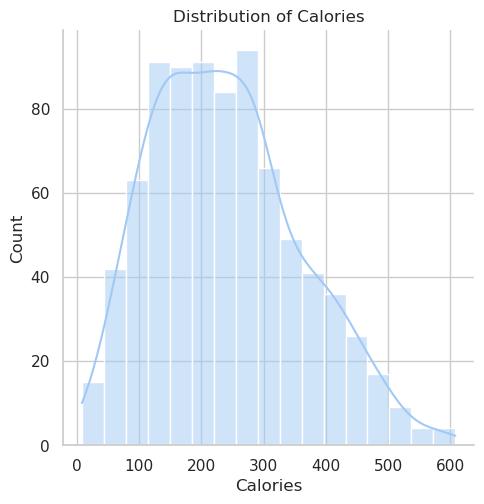

In [33]:
sns.displot(x=df["calories"], kde=True)
plt.xlabel("Calories")
plt.title("Distribution of Calories")
plt.show()

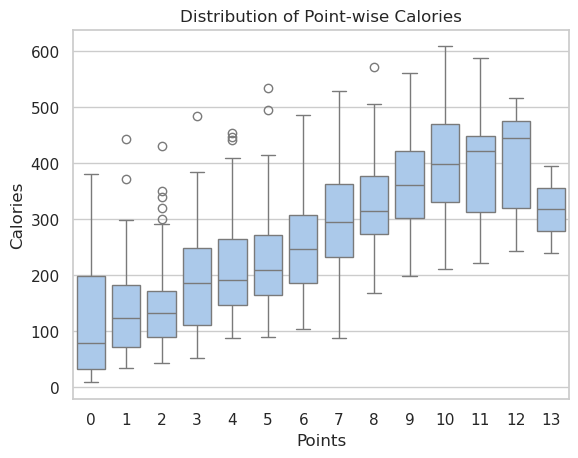

In [34]:
sns.boxplot(y=df["calories"], x=df["points"])
plt.xlabel("Points")
plt.ylabel("Calories")
plt.title("Distribution of Point-wise Calories")
plt.show()

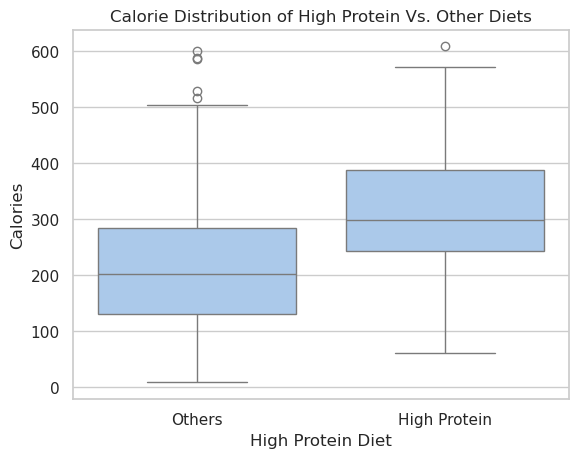

In [42]:
sns.boxplot(y=df["calories"], x=df["HP"])
plt.xlabel("High Protein Diet")
plt.xticks([0, 1], ['Others', 'High Protein'])
plt.ylabel("Calories")
plt.title("Calorie Distribution of High Protein Vs. Other Diets")
plt.show()

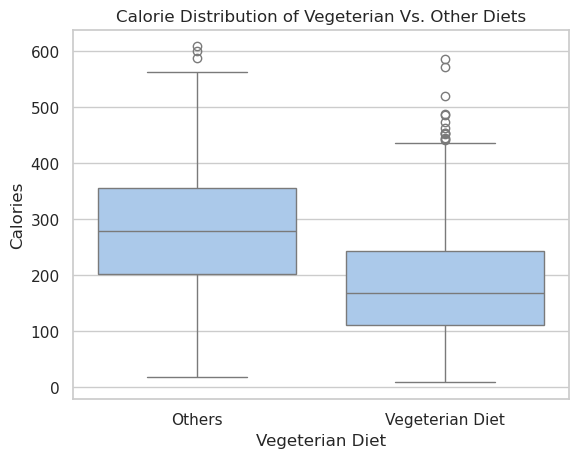

In [43]:
sns.boxplot(y=df["calories"], x=df["V"])
plt.xlabel("Vegeterian Diet")
plt.xticks([0, 1], ['Others', 'Vegeterian Diet'])
plt.ylabel("Calories")
plt.title("Calorie Distribution of Vegeterian Vs. Other Diets")
plt.show()